Epoch 0, loss: 2.1307
Epoch 50, loss: 4.7366
Epoch 100, loss: 0.0000
Epoch 150, loss: 28.5753
Epoch 200, loss: 10.4229
Epoch 250, loss: 0.0002
Epoch 300, loss: 13.7480
Epoch 350, loss: 0.1442
Epoch 400, loss: 2.1115
Epoch 450, loss: 0.0023
Epoch 500, loss: 0.0000
Epoch 550, loss: 0.0000
Epoch 600, loss: 0.0020
Epoch 650, loss: 10.9909
Epoch 700, loss: 0.0881
Epoch 750, loss: 3.5831
Epoch 800, loss: 0.0004
Epoch 850, loss: 0.0058
Epoch 900, loss: 0.0000
Epoch 950, loss: 0.0001
Epoch 1000, loss: 0.0002
Epoch 1050, loss: 0.0000
Epoch 1100, loss: 0.0020
Epoch 1150, loss: 0.0000
Epoch 1200, loss: 0.0218
Epoch 1250, loss: 0.0000
Epoch 1300, loss: 0.0000
Epoch 1350, loss: 0.0000
Epoch 1400, loss: 0.0000
Epoch 1450, loss: 0.0000
Epoch 1500, loss: 0.0000
Epoch 1550, loss: 0.0000
Epoch 1600, loss: 0.0000
Epoch 1650, loss: 6.3228
Epoch 1700, loss: 5.1018
Epoch 1750, loss: 0.0000
Epoch 1800, loss: 1.7021
Epoch 1850, loss: 0.0000
Epoch 1900, loss: 0.0005
Epoch 1950, loss: 0.0000
Epoch 2000, loss: 0

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:00<00:00, 1694.53it/s]


OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 9.81, –°—É–º–º–∞ = 981.27
–ù–µ–π—Ä–æ—Å–µ—Ç—å: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 9.81, –°—É–º–º–∞ = 981.27


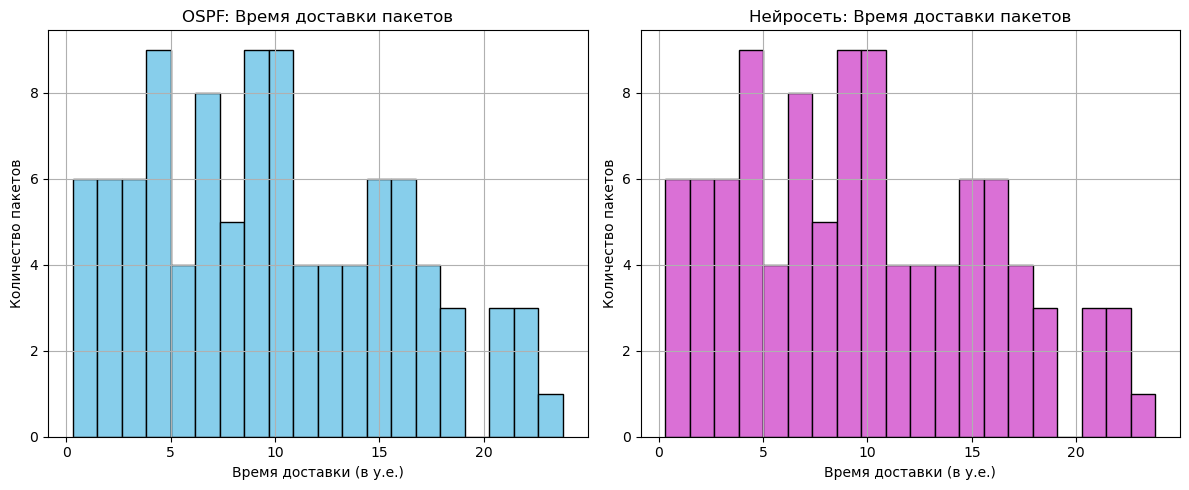

In [8]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ===== –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –≥—Ä–∞—Ñ–∞ =====
def generate_network(num_nodes=12):
    G = nx.random_geometric_graph(num_nodes, radius=0.5)
    while not nx.is_connected(G):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    for _ in range(num_nodes // 2):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.1, 3.0)
        G[u][v]['load'] = random.uniform(0.05, 1.5)
        G[u][v]['status'] = 1.0 if random.random() > 0.1 else 0.0
    return G

# ===== –ö–ª–∞—Å—Å –¥–ª—è —Ä–∞—Å–ø–∏—Å–∞–Ω–∏—è —É–∑–ª–æ–≤ =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== –°–∏–º—É–ª—è—Ü–∏—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–∞ =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        if not G.has_edge(u, v):
            return 0
        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']
    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== –ö–ª–∞—Å—Å –Ω–µ–π—Ä–æ—Å–µ—Ç–∏ =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=128):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_nodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node, edge_loads):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb, edge_loads], dim=1)
        logits = self.fc(x)
        return logits

# ===== –ü–æ–ª—É—á–µ–Ω–∏–µ –≤–µ–∫—Ç–æ—Ä–∞ –Ω–∞–≥—Ä—É–∑–æ–∫ –Ω–∞ —Ä—ë–±—Ä–∞ =====
def get_edge_loads_vector(G, current_node):
    loads = torch.zeros(len(G.nodes))
    neighbors = G[current_node.item()]
    for nbr in neighbors:
        loads[nbr] = neighbors[nbr]['load']
    return loads.unsqueeze(0)

# ===== –ü–æ–ª—É—á–µ–Ω–∏–µ –ø—É—Ç–∏ OSPF =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== –§—É–Ω–∫—Ü–∏—è –≤—ã–±–æ—Ä–∞ –¥–µ–π—Å—Ç–≤–∏—è (—Å–ª–µ–¥—É—é—â–µ–≥–æ —É–∑–ª–∞) =====
def select_action(policy_net, state, visited, G):
    logits = policy_net(state['current'], state['dst'], state['loads'])
    mask = torch.full_like(logits, float('-inf'))
    current = state['current'].item()
    for nbr in range(logits.size(1)):
        if nbr not in visited and nbr in G[current]:
            mask[0, nbr] = 0
    masked_logits = logits + mask
    probs = torch.softmax(masked_logits, dim=1)
    action = torch.multinomial(probs, 1).item()
    return action, torch.log(probs[0, action])

# ===== –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ =====
def train_routing_net():
    G = generate_network(12)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    epochs = 20000
    for epoch in range(epochs):
        total_loss = 0
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        path = [current]
        visited = set(path)
        scheduler = NodeScheduler(num_nodes)
        max_hops = num_nodes * 2

        while current != dst and len(path) < max_hops:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            edge_loads = get_edge_loads_vector(G, current_tensor[0])

            state = {
                'current': current_tensor,
                'dst': dst_tensor,
                'loads': edge_loads
            }

            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(num_nodes):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]
            if target_next in visited:
                break
            target = torch.tensor([target_next])

            loss = loss_fn(masked_logits, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            current = target_next
            visited.add(current)
            path.append(current)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

# ===== –ü–æ–ª—É—á–µ–Ω–∏–µ –º–∞—Ä—à—Ä—É—Ç–∞ –∏–∑ –º–æ–¥–µ–ª–∏ =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        edge_loads = get_edge_loads_vector(G, current_tensor[0])

        net.eval()
        with torch.no_grad():
            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(len(G.nodes)):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            probs = torch.softmax(masked_logits, dim=1)
            next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node):
            return None

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None

    return path

# ===== –û—Å–Ω–æ–≤–Ω–∞—è —Å–∏–º—É–ª—è—Ü–∏—è =====
def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = ospf_path(G, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ =====
def visualize(delivery_times_ospf, delivery_times_nn):
    valid_ospf = [t for t in delivery_times_ospf if t > 0]
    valid_nn = [t for t in delivery_times_nn if t > 0]

    print(f"OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(valid_ospf):.2f}, –°—É–º–º–∞ = {np.sum(valid_ospf):.2f}")
    print(f"–ù–µ–π—Ä–æ—Å–µ—Ç—å: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(valid_nn):.2f}, –°—É–º–º–∞ = {np.sum(valid_nn):.2f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(valid_ospf, bins=20, color='skyblue', edgecolor='black')
    plt.title("OSPF: –í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–æ–≤")
    plt.xlabel("–í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ (–≤ —É.–µ.)")
    plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞–∫–µ—Ç–æ–≤")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(valid_nn, bins=20, color='orchid', edgecolor='black')
    plt.title("–ù–µ–π—Ä–æ—Å–µ—Ç—å: –í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–æ–≤")
    plt.xlabel("–í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ (–≤ —É.–µ.)")
    plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞–∫–µ—Ç–æ–≤")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ===== –ó–∞–ø—É—Å–∫ –≤—Å–µ–≥–æ =====
delivery_times_ospf, delivery_times_nn = run_simulation()
visualize(delivery_times_ospf, delivery_times_nn)


  0%|                                                                              | 88/57000 [00:00<02:07, 446.10it/s]

Epoch 0, loss: 20.2831


  2%|‚ñà‚ñç                                                                          | 1080/57000 [00:02<01:42, 547.45it/s]

Epoch 1000, loss: 1.5474


  4%|‚ñà‚ñà‚ñã                                                                         | 2053/57000 [00:04<01:53, 483.46it/s]

Epoch 2000, loss: 3.3312


  5%|‚ñà‚ñà‚ñà‚ñà                                                                        | 3047/57000 [00:05<01:38, 548.00it/s]

Epoch 3000, loss: 2.4401


  7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                      | 4083/57000 [00:07<01:40, 527.25it/s]

Epoch 4000, loss: 0.7199


  9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                     | 5073/57000 [00:09<01:39, 524.21it/s]

Epoch 5000, loss: 1.7038


 11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                   | 6094/57000 [00:11<01:39, 509.93it/s]

Epoch 6000, loss: 2.3188


 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                  | 7099/57000 [00:13<01:36, 515.92it/s]

Epoch 7000, loss: 0.0007


 14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                 | 8060/57000 [00:15<01:44, 469.25it/s]

Epoch 8000, loss: 2.0919


 16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                | 9074/57000 [00:17<01:34, 509.59it/s]

Epoch 9000, loss: 1.1804


 18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                             | 10095/57000 [00:19<01:27, 534.92it/s]

Epoch 10000, loss: 4.9513


 19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                            | 11073/57000 [00:21<01:31, 504.21it/s]

Epoch 11000, loss: 2.5298


 21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                           | 12030/57000 [00:23<01:29, 505.04it/s]

Epoch 12000, loss: 1.9276


 23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                         | 13088/57000 [00:25<01:24, 521.18it/s]

Epoch 13000, loss: 1.8686


 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 14091/57000 [00:27<01:22, 518.10it/s]

Epoch 14000, loss: 2.0401


 27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                       | 15123/57000 [00:29<01:19, 524.77it/s]

Epoch 15000, loss: 2.3054


 28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                     | 16100/57000 [00:31<01:15, 541.07it/s]

Epoch 16000, loss: 1.7269


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                    | 17099/57000 [00:33<01:13, 542.99it/s]

Epoch 17000, loss: 4.2990


 32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 18066/57000 [00:35<01:17, 503.18it/s]

Epoch 18000, loss: 1.5106


 33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                  | 19084/57000 [00:37<01:13, 516.92it/s]

Epoch 19000, loss: 2.4300


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                | 20067/57000 [00:39<01:08, 539.57it/s]

Epoch 20000, loss: 1.9471


 37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                               | 21105/57000 [00:41<01:05, 549.22it/s]

Epoch 21000, loss: 1.6768


 39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                              | 22079/57000 [00:42<01:03, 547.39it/s]

Epoch 22000, loss: 2.1913


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                            | 23041/57000 [00:44<01:05, 515.62it/s]

Epoch 23000, loss: 1.7700


 42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 24050/57000 [00:46<01:02, 524.91it/s]

Epoch 24000, loss: 0.0000


 44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 25042/57000 [00:48<01:08, 469.64it/s]

Epoch 25000, loss: 3.1908


 46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                        | 26058/57000 [00:50<01:00, 510.18it/s]

Epoch 26000, loss: 3.6810


 48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                       | 27076/57000 [00:52<00:55, 539.07it/s]

Epoch 27000, loss: 2.3409


 49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                      | 28079/57000 [00:54<00:54, 533.95it/s]

Epoch 28000, loss: 4.5520


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                    | 29095/57000 [00:56<00:51, 545.90it/s]

Epoch 29000, loss: 2.1465


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 30065/57000 [00:58<00:52, 513.55it/s]

Epoch 30000, loss: 2.7321


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                  | 31086/57000 [01:00<00:48, 537.51it/s]

Epoch 31000, loss: 4.3576


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                | 32094/57000 [01:02<00:49, 503.36it/s]

Epoch 32000, loss: 2.9871


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                               | 33079/57000 [01:04<00:46, 513.05it/s]

Epoch 33000, loss: 6.1511


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                              | 34092/57000 [01:06<00:42, 537.01it/s]

Epoch 34000, loss: 2.0733


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                            | 35087/57000 [01:08<00:43, 503.36it/s]

Epoch 35000, loss: 2.3749


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                           | 36041/57000 [01:10<00:42, 488.37it/s]

Epoch 36000, loss: 3.8287


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 37086/57000 [01:12<00:42, 470.44it/s]

Epoch 37000, loss: 2.4344


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                         | 38091/57000 [01:14<00:39, 480.47it/s]

Epoch 38000, loss: 3.2227


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                       | 39060/57000 [01:16<00:36, 491.71it/s]

Epoch 39000, loss: 2.1524


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                      | 40092/57000 [01:18<00:32, 525.16it/s]

Epoch 40000, loss: 2.3998


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                     | 41061/57000 [01:20<00:31, 512.94it/s]

Epoch 41000, loss: 4.2816


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                   | 42064/57000 [01:22<00:30, 497.02it/s]

Epoch 42000, loss: 2.1678


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 43081/57000 [01:24<00:28, 480.97it/s]

Epoch 43000, loss: 4.6814


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                 | 44101/57000 [01:26<00:25, 513.28it/s]

Epoch 44000, loss: 3.5336


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé               | 45067/57000 [01:28<00:21, 552.77it/s]

Epoch 45000, loss: 1.4706


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã              | 46084/57000 [01:30<00:19, 550.17it/s]

Epoch 46000, loss: 2.0291


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ             | 47101/57000 [01:32<00:18, 534.50it/s]

Epoch 47000, loss: 5.1685


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé           | 48088/57000 [01:33<00:16, 536.57it/s]

Epoch 48000, loss: 4.4489


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 49067/57000 [01:35<00:16, 487.50it/s]

Epoch 49000, loss: 5.1634


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 50055/57000 [01:37<00:13, 521.98it/s]

Epoch 50000, loss: 5.2278


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè       | 51054/57000 [01:39<00:12, 487.63it/s]

Epoch 51000, loss: 2.1451


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå      | 52064/57000 [01:41<00:09, 501.25it/s]

Epoch 52000, loss: 1.5889


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä     | 53088/57000 [01:43<00:08, 482.25it/s]

Epoch 53000, loss: 3.9848


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 54094/57000 [01:46<00:05, 514.21it/s]

Epoch 54000, loss: 2.8079


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 55084/57000 [01:48<00:04, 434.11it/s]

Epoch 55000, loss: 2.3990


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 56058/57000 [01:50<00:02, 443.81it/s]

Epoch 56000, loss: 2.7665


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 200/200 [00:00<00:00, 481.63it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_4876\2651458043.py:267: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([valid_ospf, valid_nn], labels=['OSPF', '–ù–µ–π—Ä–æ—Å–µ—Ç—å'])


OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 17.61, –°—É–º–º–∞ = 3521.94
–ù–µ–π—Ä–æ—Å–µ—Ç—å: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 21.81, –°—É–º–º–∞ = 4362.44


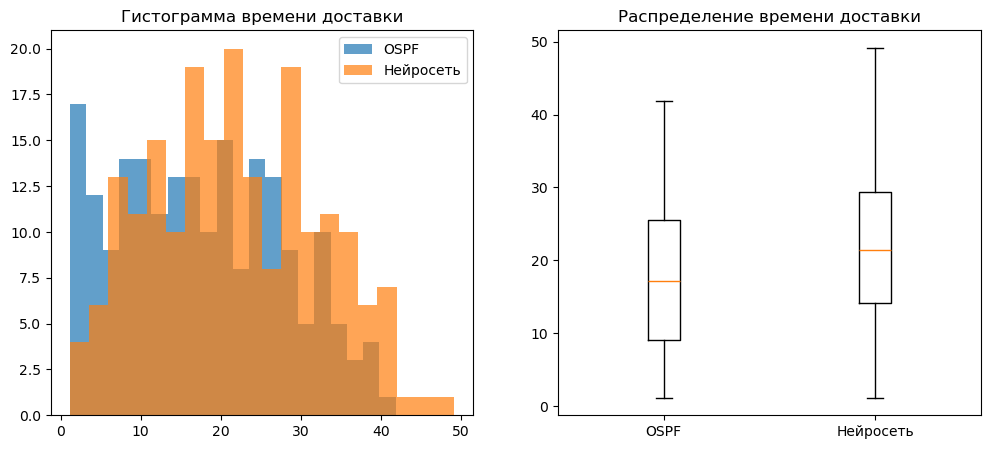

In [12]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ===== –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –≥—Ä–∞—Ñ–∞ =====
def generate_network(num_nodes=12):
    G = nx.random_geometric_graph(num_nodes, radius=0.5)
    
    while not nx.is_connected(G):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    additional_edges = num_nodes // 2
    for _ in range(additional_edges):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    # –ò–∑–Ω–∞—á–∞–ª—å–Ω–æ –∑–∞–¥–∞—ë–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —Ä—ë–±–µ—Ä
    for u, v in G.edges():
        G[u][v]['base_latency'] = random.uniform(0.5, 2.0)
        G[u][v]['base_load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = 1.0  # –≤—Å–µ —Ä–µ–±—Ä–∞ –∞–∫—Ç–∏–≤–Ω—ã –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ
    
    return G

# ===== –û–±–Ω–æ–≤–ª–µ–Ω–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ —Ä—ë–±–µ—Ä (–¥–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–µ —Å–±–æ–∏ –∏ –∏–∑–º–µ–Ω–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫) =====
def update_edge_params(G):
    for u, v in G.edges():
        # –°–±–æ–π —Ä–µ–±—Ä–∞ —Å –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é 15%
        G[u][v]['status'] = 0.0 if random.random() < 0.15 else 1.0
        
        if G[u][v]['status'] == 1.0:
            # –µ—Å–ª–∏ —Ä–µ–±—Ä–æ –∞–∫—Ç–∏–≤–Ω–æ, –º–µ—Ç—Ä–∏–∫–∏ –º–µ–Ω—è—é—Ç—Å—è —Å–ª—É—á–∞–π–Ω–æ –æ–∫–æ–ª–æ –±–∞–∑–æ–≤—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π
            G[u][v]['latency'] = G[u][v]['base_latency'] * random.uniform(0.8, 1.5)
            G[u][v]['load'] = min(1.5, G[u][v]['base_load'] * random.uniform(0.5, 2.0))
        else:
            # –µ—Å–ª–∏ —Ä–µ–±—Ä–æ —Å–±–æ–π–Ω–æ–µ ‚Äî –æ—á–µ–Ω—å –≤—ã—Å–æ–∫–∞—è –∑–∞–¥–µ—Ä–∂–∫–∞
            G[u][v]['latency'] = 1000.0
            G[u][v]['load'] = 10.0

# ===== –ö–ª–∞—Å—Å —Å–æ—Å—Ç–æ—è–Ω–∏—è —É–∑–ª–æ–≤ (–æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ –Ω–∞ –æ–¥–Ω–æ–≤—Ä–µ–º–µ–Ω–Ω—É—é –ø–µ—Ä–µ–¥–∞—á—É) =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== –°–∏–º—É–ª—è—Ü–∏—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–∞ =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v) or G[u][v]['status'] == 0.0:
            return 0  # —Ä–µ–±—Ä–æ –Ω–µ–¥–æ—Å—Ç—É–ø–Ω–æ

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']

    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== OSPF –º–∞—Ä—à—Ä—É—Ç —Å —É—á—ë—Ç–æ–º –¥–æ—Å—Ç—É–ø–Ω–æ—Å—Ç–∏ —Ä–µ–±–µ—Ä (–∏—Å–ø–æ–ª—å–∑—É–µ–º latency, –Ω–æ –∏–≥–Ω–æ—Ä–∏—Ä—É–µ–º —Å—Ç–∞—Ç—É—Å) =====
def ospf_path(G, src, dst):
    # –î–ª—è OSPF –º—ã –∏—Å–ø–æ–ª—å–∑—É–µ–º latency, –Ω–æ —É–¥–∞–ª—è–µ–º –Ω–µ–¥–æ—Å—Ç—É–ø–Ω—ã–µ —Ä–µ–±—Ä–∞ –∏–∑ –≥—Ä–∞—Ñ–∞ –≤—Ä–µ–º–µ–Ω–Ω–æ
    H = G.copy()
    for u, v in list(H.edges()):
        if H[u][v]['status'] == 0.0:
            H.remove_edge(u, v)
    try:
        return nx.shortest_path(H, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== –ù–µ–π—Ä–æ—Å–µ—Ç—å =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=128):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_nodes * 3, hidden_dim),  # –¥–æ–±–∞–≤–∏–º 3 –º–µ—Ç—Ä–∏–∫–∏ –ø–æ —Ä—ë–±—Ä–∞–º (latency, load, status)
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node, edge_feats):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb, edge_feats], dim=1)
        logits = self.fc(x)
        return logits

# ===== –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –≤—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –Ω–µ–π—Ä–æ—Å–µ—Ç–∏ =====
def get_edge_features(G, current_node):
    # –í–æ–∑–≤—Ä–∞—â–∞–µ–º –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —É–∑–ª–∞: latency, load, status —Ä—ë–±–µ—Ä –æ—Ç current_node (–µ—Å–ª–∏ —Ä–µ–±—Ä–æ –µ—Å—Ç—å)
    num_nodes = len(G.nodes)
    latency = torch.zeros(num_nodes)
    load = torch.zeros(num_nodes)
    status = torch.zeros(num_nodes)

    neighbors = G[current_node.item()]
    for nbr in neighbors:
        latency[nbr] = G[current_node.item()][nbr]['latency']
        load[nbr] = G[current_node.item()][nbr]['load']
        status[nbr] = G[current_node.item()][nbr]['status']

    edge_feats = torch.cat([latency, load, status], dim=0).unsqueeze(0)  # —Ä–∞–∑–º–µ—Ä (1, num_nodes * 3)
    return edge_feats

# ===== –û–±—É—á–µ–Ω–∏–µ =====
def train_routing_net():
    G = generate_network(12)
    net = RoutingNet(len(G.nodes))
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    loss_fn = nn.CrossEntropyLoss()
    epochs = 57000

    for epoch in tqdm(range(epochs)):
        update_edge_params(G)

        src, dst = random.sample(list(G.nodes), 2)
        current = src
        path = [current]
        visited = set(path)
        scheduler = NodeScheduler(len(G.nodes))
        max_hops = len(G.nodes) * 2

        total_loss = 0
        while current != dst and len(path) < max_hops:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            edge_feats = get_edge_features(G, current_tensor)

            logits = net(current_tensor, dst_tensor, edge_feats)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(len(G.nodes)):
                if v not in visited and G.has_edge(current, v) and G[current][v]['status'] == 1.0:
                    mask[0, v] = 0
            masked_logits = logits + mask

            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]
            if target_next in visited:
                break
            target = torch.tensor([target_next])

            loss = loss_fn(masked_logits, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            current = target_next
            visited.add(current)
            path.append(current)

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

# ===== –ü–æ–ª—É—á–µ–Ω–∏–µ –º–∞—Ä—à—Ä—É—Ç–∞ –∏–∑ –º–æ–¥–µ–ª–∏ =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        edge_feats = get_edge_features(G, current_tensor)

        net.eval()
        with torch.no_grad():
            logits = net(current_tensor, dst_tensor, edge_feats)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(len(G.nodes)):
                if v not in visited and G.has_edge(current, v) and G[current][v]['status'] == 1.0:
                    mask[0, v] = 0
            masked_logits = logits + mask

            probs = torch.softmax(masked_logits, dim=1)
            next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node) or G[current][next_node]['status'] == 0.0:
            return None  # –∑–∞—Ü–∏–∫–ª–∏–≤–∞–Ω–∏–µ –∏–ª–∏ –Ω–µ–¥–æ–ø—É—Å—Ç–∏–º—ã–π –ø–µ—Ä–µ—Ö–æ–¥

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None

    return path

# ===== –û—Å–Ω–æ–≤–Ω–∞—è —Å–∏–º—É–ª—è—Ü–∏—è =====
def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 200
    delivery_times_ospf = []
    delivery_times_nn = []
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    for _ in tqdm(pairs):
        update_edge_params(G)  # –æ–±–Ω–æ–≤–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è –∫–∞–∂–¥–æ–π –ø–∞—Ä—ã

        src, dst = _[0], _[1]
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = path_ospf

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ =====
def visualize(delivery_times_ospf, delivery_times_nn):
    valid_ospf = [t for t in delivery_times_ospf if t > 0]
    valid_nn = [t for t in delivery_times_nn if t > 0]

    print(f"OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(valid_ospf):.2f}, –°—É–º–º–∞ = {np.sum(valid_ospf):.2f}")
    print(f"–ù–µ–π—Ä–æ—Å–µ—Ç—å: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(valid_nn):.2f}, –°—É–º–º–∞ = {np.sum(valid_nn):.2f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(valid_ospf, bins=20, alpha=0.7, label='OSPF')
    plt.hist(valid_nn, bins=20, alpha=0.7, label='–ù–µ–π—Ä–æ—Å–µ—Ç—å')
    plt.title('–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ –≤—Ä–µ–º–µ–Ω–∏ –¥–æ—Å—Ç–∞–≤–∫–∏')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot([valid_ospf, valid_nn], labels=['OSPF', '–ù–µ–π—Ä–æ—Å–µ—Ç—å'])
    plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–∏ –¥–æ—Å—Ç–∞–≤–∫–∏')
    plt.show()

# ===== –ó–∞–ø—É—Å–∫ =====
if __name__ == '__main__':
    delivery_times_ospf, delivery_times_nn = run_simulation()
    visualize(delivery_times_ospf, delivery_times_nn)


Epoch 0, loss: 1.9831
Epoch 50, loss: 3.2039
Epoch 100, loss: 0.0000
Epoch 150, loss: 0.0794
Epoch 200, loss: 0.0062
Epoch 250, loss: 0.0000
Epoch 300, loss: 5.9576
Epoch 350, loss: 0.0000
Epoch 400, loss: 0.0000
Epoch 450, loss: 0.2494
Epoch 500, loss: 0.1123
Epoch 550, loss: 0.0014
Epoch 600, loss: 0.0001
Epoch 650, loss: 0.4264
Epoch 700, loss: 0.0000
Epoch 750, loss: 0.0000
Epoch 800, loss: 0.0000
Epoch 850, loss: 0.0011
Epoch 900, loss: 0.0018
Epoch 950, loss: 0.0000
Epoch 1000, loss: 0.0000
Epoch 1050, loss: 0.0000
Epoch 1100, loss: 0.0000
Epoch 1150, loss: 0.0000
Epoch 1200, loss: 0.0000
Epoch 1250, loss: 0.0000
Epoch 1300, loss: 0.0000
Epoch 1350, loss: 0.0010
Epoch 1400, loss: 0.0000
Epoch 1450, loss: 0.0000
Epoch 1500, loss: 0.0000
Epoch 1550, loss: 0.0005
Epoch 1600, loss: 0.0000
Epoch 1650, loss: 0.0000
Epoch 1700, loss: 0.0000
Epoch 1750, loss: 0.0000
Epoch 1800, loss: 0.0002
Epoch 1850, loss: 0.0000
Epoch 1900, loss: 0.0000
Epoch 1950, loss: 0.0000
Epoch 2000, loss: 0.000

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:00<00:00, 1678.57it/s]

OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 10.12, –°—É–º–º–∞ = 1011.56
NN:   –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 10.12, –°—É–º–º–∞ = 1011.56


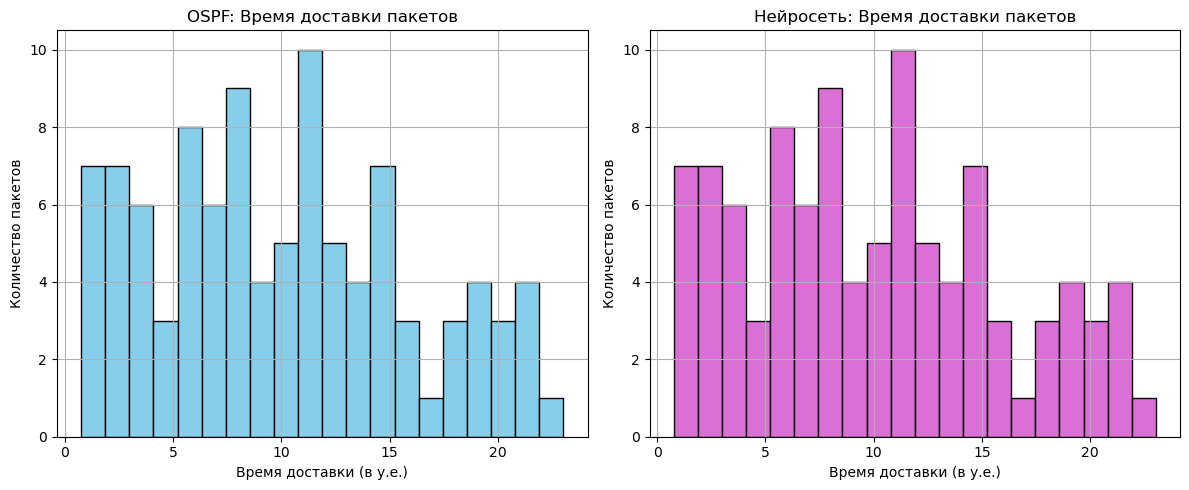

In [16]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ===== –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –≥—Ä–∞—Ñ–∞ =====
def generate_network(num_nodes=40):
    G = nx.random_geometric_graph(num_nodes, radius=0.4)

    while not nx.is_connected(G):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)

    additional_edges = num_nodes // 2
    for _ in range(additional_edges):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)

    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.1, 3.0)
        G[u][v]['packet_loss'] = random.uniform(0.005, 0.15)
        G[u][v]['load'] = random.uniform(0.05, 1.5)
        G[u][v]['status'] = 1.0 if random.random() > 0.1 else 0.0

    return G

# ===== –ö–ª–∞—Å—Å —Å–æ—Å—Ç–æ—è–Ω–∏—è —É–∑–ª–æ–≤ =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== –°–∏–º—É–ª—è—Ü–∏—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–∞ =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v):
            return 0

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']

    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== OSPF –º–∞—Ä—à—Ä—É—Ç =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== –ù–µ–π—Ä–æ—Å–µ—Ç—å =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=128):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_nodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node, edge_loads):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb, edge_loads], dim=1)
        logits = self.fc(x)
        return logits

# ===== –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –≤—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö =====
def get_edge_loads_vector(G, current_node):
    loads = torch.zeros(len(G.nodes))
    neighbors = G[current_node.item()]
    for nbr in neighbors:
        loads[nbr] = neighbors[nbr]['load']
    return loads.unsqueeze(0)  # (1, num_nodes)

# ===== –û–±—É—á–µ–Ω–∏–µ =====
def train_routing_net():
    G = generate_network(12)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    epochs = 30000
    for epoch in range(epochs):
        total_loss = 0
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        path = [current]
        visited = set(path)
        scheduler = NodeScheduler(num_nodes)
        max_hops = num_nodes * 2

        while current != dst and len(path) < max_hops:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            edge_loads = get_edge_loads_vector(G, current_tensor[0])

            logits = net(current_tensor, dst_tensor, edge_loads)

            # –ú–∞—Å–∫–∏—Ä—É–µ–º –ø–æ—Å–µ—â—ë–Ω–Ω—ã–µ —É–∑–ª—ã –∏ –æ—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏–µ —Ä–µ–±—Ä–∞
            mask = torch.full_like(logits, float('-inf'))
            for v in range(num_nodes):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            # –¶–µ–ª–µ–≤–æ–π —Å–ª–µ–¥—É—é—â–∏–π —É–∑–µ–ª ‚Äî –±–µ—Ä–µ–º –∏–∑ OSPF –ø—É—Ç–∏
            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]
            if target_next in visited:
                break
            target = torch.tensor([target_next])

            loss = loss_fn(masked_logits, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            current = target_next
            visited.add(current)
            path.append(current)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

# ===== –ü–æ–ª—É—á–µ–Ω–∏–µ –º–∞—Ä—à—Ä—É—Ç–∞ –∏–∑ –º–æ–¥–µ–ª–∏ =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        edge_loads = get_edge_loads_vector(G, current_tensor[0])

        net.eval()
        with torch.no_grad():
            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(len(G.nodes)):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            probs = torch.softmax(masked_logits, dim=1)
            next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node):
            return None

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None

    return path

# ===== –û—Å–Ω–æ–≤–Ω–∞—è —Å–∏–º—É–ª—è—Ü–∏—è =====
def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = ospf_path(G, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    valid_ospf = [t for t in delivery_times_ospf if t > 0]
    valid_nn = [t for t in delivery_times_nn if t > 0]

    print(f"OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(valid_ospf):.2f}, –°—É–º–º–∞ = {np.sum(valid_ospf):.2f}")
    print(f"NN:   –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(valid_nn):.2f}, –°—É–º–º–∞ = {np.sum(valid_nn):.2f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(valid_ospf, bins=20, color='skyblue', edgecolor='black')
    plt.title("OSPF: –í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–æ–≤")
    plt.xlabel("–í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ (–≤ —É.–µ.)")
    plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞–∫–µ—Ç–æ–≤")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(valid_nn, bins=20, color='orchid', edgecolor='black')
    plt.title("–ù–µ–π—Ä–æ—Å–µ—Ç—å: –í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–æ–≤")
    plt.xlabel("–í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ (–≤ —É.–µ.)")
    plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞–∫–µ—Ç–æ–≤")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_simulation()


In [19]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ===== –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Å–ª–æ–∂–Ω–æ–π —Å–µ—Ç–∏ =====
def generate_complex_network(num_nodes=40):
    # –°–æ–∑–¥–∞–µ–º —Å–ª—É—á–∞–π–Ω—ã–π –≥–µ–æ–º–µ—Ç—Ä–∏—á–µ—Å–∫–∏–π –≥—Ä–∞—Ñ —Å —Ä–∞–¥–∏—É—Å–æ–º —Å–≤—è–∑–∏
    G = nx.random_geometric_graph(num_nodes, radius=0.3)
    
    # –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ –≥—Ä–∞—Ñ —Å–≤—è–∑–Ω—ã–π
    while not nx.is_connected(G):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)

    # –î–æ–±–∞–≤–∏–º –º–Ω–æ–≥–æ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã—Ö —Ä–µ–±–µ—Ä, —á—Ç–æ–±—ã –∑–∞–ø—É—Ç–∞—Ç—å –≥—Ä–∞—Ñ
    additional_edges = num_nodes * 3
    for _ in range(additional_edges):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    # –ó–∞–¥–∞–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —Ä–µ–±—Ä–∞–º ‚Äî —Ä–∞—Å—à–∏—Ä–µ–Ω–Ω—ã–π —Ä–∞–∑–±—Ä–æ—Å, –º–Ω–æ–∂–µ—Å—Ç–≤–æ –Ω–µ—Ä–∞–±–æ—á–∏—Ö —Ä–µ–±–µ—Ä
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(1.0, 10.0)         # –≤—ã—Å–æ–∫–∞—è –≤–∞—Ä–∏–∞—Ç–∏–≤–Ω–æ—Å—Ç—å –∑–∞–¥–µ—Ä–∂–µ–∫
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.3)     # –±–æ–ª–µ–µ –≤—ã—Å–æ–∫–∏–µ –ø–æ—Ç–µ—Ä–∏
        G[u][v]['load'] = random.uniform(0.1, 3.0)              # –Ω–∞–≥—Ä—É–∑–∫–∞ –≤—ã—à–µ 1
        # 30% —Ä–µ–±–µ—Ä –Ω–µ—Ä–∞–±–æ—á–∏–µ (—Å—Ç–∞—Ç—É—Å 0)
        G[u][v]['status'] = 1.0 if random.random() > 0.3 else 0.0

    return G

# ===== –ö–ª–∞—Å—Å —Å–æ—Å—Ç–æ—è–Ω–∏—è —É–∑–ª–æ–≤ =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== –°–∏–º—É–ª—è—Ü–∏—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–∞ =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v) or G[u][v]['status'] == 0.0:
            return 0  # –ø—É—Ç—å –Ω–µ–¥–æ—Å—Ç—É–ø–µ–Ω –∏–∑-–∑–∞ –Ω–µ—Ä–∞–±–æ—á–µ–≥–æ —Ä–µ–±—Ä–∞

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']

    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== OSPF –º–∞—Ä—à—Ä—É—Ç (–∫–æ—Ä–æ—Ç—á–∞–π—à–∏–π –ø—É—Ç—å –ø–æ latency, —Ç–æ–ª—å–∫–æ —á–µ—Ä–µ–∑ —Ä–∞–±–æ—á–∏–µ —Ä–µ–±—Ä–∞) =====
def ospf_path(G, src, dst):
    # –°–æ–∑–¥–∞–µ–º –ø–æ–¥–≥—Ä–∞—Ñ —Ç–æ–ª—å–∫–æ —Å –∞–∫—Ç–∏–≤–Ω—ã–º–∏ —Ä–µ–±—Ä–∞–º–∏
    active_edges = [(u,v) for u,v in G.edges() if G[u][v]['status'] == 1.0]
    H = G.edge_subgraph(active_edges)
    try:
        return nx.shortest_path(H, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== –ù–µ–π—Ä–æ—Å–µ—Ç—å –º–∞—Ä—à—Ä—É—Ç–∏–∑–∞—Ü–∏–∏ =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=128):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_nodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node, edge_loads):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb, edge_loads], dim=1)
        logits = self.fc(x)
        return logits

# ===== –í–µ–∫—Ç–æ—Ä –Ω–∞–≥—Ä—É–∑–æ–∫ —Ä—ë–±–µ—Ä –∏–∑ —Ç–µ–∫—É—â–µ–≥–æ —É–∑–ª–∞ =====
def get_edge_loads_vector(G, current_node):
    loads = torch.zeros(len(G.nodes))
    neighbors = G[current_node.item()]
    for nbr in neighbors:
        if G[current_node.item()][nbr]['status'] == 1.0:
            loads[nbr] = G[current_node.item()][nbr]['load']
    return loads.unsqueeze(0)

# ===== –û–±—É—á–µ–Ω–∏–µ –Ω–µ–π—Ä–æ—Å–µ—Ç–∏ =====
def train_routing_net(epochs=50000):
    G = generate_complex_network(40)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        path = [current]
        visited = set(path)
        max_hops = num_nodes * 2

        while current != dst and len(path) < max_hops:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            edge_loads = get_edge_loads_vector(G, current_tensor[0])

            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, -1e9)
            for v in range(num_nodes):
                if v not in visited and G.has_edge(current, v) and G[current][v]['status'] == 1.0:
                    mask[0, v] = 0
            masked_logits = logits + mask

            if torch.isnan(masked_logits).any() or torch.isinf(masked_logits).any():
                # –ü—Ä–æ–ø—É—Å–∫–∞–µ–º –∏—Ç–µ—Ä–∞—Ü–∏—é –ø—Ä–∏ –æ—à–∏–±–∫–∞—Ö —á–∏—Å–ª–æ–≤–æ–π —Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç–∏
                break

            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]
            if target_next in visited:
                break

            target = torch.tensor([target_next])

            loss = loss_fn(masked_logits, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            current = target_next
            visited.add(current)
            path.append(current)

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

# ===== –ü–æ–ª—É—á–µ–Ω–∏–µ –º–∞—Ä—à—Ä—É—Ç–∞ –∏–∑ –º–æ–¥–µ–ª–∏ =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        edge_loads = get_edge_loads_vector(G, current_tensor[0])

        net.eval()
        with torch.no_grad():
            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, -1e9)
            for v in range(len(G.nodes)):
                if v not in visited and G.has_edge(current, v) and G[current][v]['status'] == 1.0:
                    mask[0, v] = 0
            masked_logits = logits + mask

            if torch.isnan(masked_logits).any() or torch.isinf(masked_logits).any():
                return None

            probs = F.softmax(masked_logits, dim=1)
            next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node) or G[current][next_node]['status'] == 0.0:
            return None  # –∑–∞—Ü–∏–∫–ª–∏–≤–∞–Ω–∏–µ –∏–ª–∏ –Ω–µ–¥–æ–ø—É—Å—Ç–∏–º—ã–π –ø–µ—Ä–µ—Ö–æ–¥

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None

    return path

# ===== –û—Å–Ω–æ–≤–Ω–∞—è —Å–∏–º—É–ª—è—Ü–∏—è =====
def run_simulation():
    G, net = train_routing_net(epochs=50000)
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 200
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = ospf_path(G, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ =====
def visualize_results(delivery_times_ospf, delivery_times_nn):
    valid_ospf = [t for t in delivery_times_ospf if t > 0]
    valid_nn = [t for t in delivery_times_nn if t > 0]

    print(f"OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(valid_ospf):.2f}, –°—É–º–º–∞ = {np.sum(valid_ospf):.2f}")
    print(f"NN:   –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(valid_nn):.2f}, –°—É–º–º–∞ = {np.sum(valid_nn):.2f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(valid_ospf, bins=30, color='skyblue', edgecolor='black')
    plt.title("OSPF: –í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–æ–≤")
    plt.xlabel("–í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ (—É—Å–ª–æ–≤–Ω—ã–µ –µ–¥–∏–Ω–∏—Ü—ã)")
    plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞–∫–µ—Ç–æ–≤")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(valid_nn, bins=30, color='orchid', edgecolor='black')
    plt.title("–ù–µ–π—Ä–æ—Å–µ—Ç—å: –í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ –ø–∞–∫–µ—Ç–æ–≤")
    plt.xlabel("–í—Ä–µ–º—è –¥–æ—Å—Ç–∞–≤–∫–∏ (—É—Å–ª–æ–≤–Ω—ã–µ –µ–¥–∏–Ω–∏—Ü—ã)")
    plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞–∫–µ—Ç–æ–≤")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ===== –ó–∞–ø—É—Å–∫ =====
if __name__ == "__main__":
    delivery_times_ospf, delivery_times_nn = run_simulation()
    visualize_results(delivery_times_ospf, delivery_times_nn)


Epoch 0, loss: 2.2807
Epoch 500, loss: 17.1456
Epoch 1000, loss: 7.0999
Epoch 1500, loss: 0.0037
Epoch 2000, loss: 1.6014
Epoch 2500, loss: 0.0169
Epoch 3000, loss: 3.6437
Epoch 3500, loss: 0.0000
Epoch 4000, loss: 0.0279
Epoch 4500, loss: 0.0613
Epoch 5000, loss: 0.0000
Epoch 5500, loss: 0.0000
Epoch 6000, loss: 0.0054
Epoch 6500, loss: 0.0000
Epoch 7000, loss: 0.0000
Epoch 7500, loss: 0.1428
Epoch 8000, loss: 0.5861
Epoch 8500, loss: 0.8052
Epoch 9000, loss: 0.0005
Epoch 9500, loss: 0.0000
Epoch 10000, loss: 0.0000
Epoch 10500, loss: 0.8008
Epoch 11000, loss: 0.0066
Epoch 11500, loss: 0.0000
Epoch 12000, loss: 0.0013
Epoch 12500, loss: 0.0003
Epoch 13000, loss: 0.0000
Epoch 13500, loss: 0.0000
Epoch 14000, loss: 0.0000
Epoch 14500, loss: 0.0000
Epoch 15000, loss: 0.0000
Epoch 15500, loss: 0.0000
Epoch 16000, loss: 0.0000
Epoch 16500, loss: 0.0000
Epoch 17000, loss: 0.0000
Epoch 17500, loss: 0.0000
Epoch 18000, loss: 0.0000
Epoch 18500, loss: 11.5208
Epoch 19000, loss: 0.0000
Epoch 19

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 200/200 [00:00<00:00, 841.19it/s]


OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 12.03, –°—É–º–º–∞ = 2406.15
NN:   –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 12.10, –°—É–º–º–∞ = 2419.79


In [22]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ===== –ñ—ë—Å—Ç–∫–æ –∑–∞–¥–∞–Ω–Ω–∞—è —Å–µ—Ç—å —Å 10 —É–∑–ª–∞–º–∏ =====
def generate_hard_network():
    G = nx.Graph()

    # –î–æ–±–∞–≤–∏–º —É–∑–ª—ã
    for i in range(10):
        G.add_node(i)

    # –°–æ–∑–¥–∞–µ–º –¥–≤–µ –ø–æ–¥—Å–µ—Ç–∏: 0-1-2-3 –∏ 3-4-5-6-7-8-9 (—É–∑–µ–ª 3 ‚Äî –º–æ—Å—Ç)
    edges_subnet1 = [(0,1), (1,2), (2,3)]
    edges_subnet2 = [(3,4), (4,5), (5,6), (6,7), (7,8), (8,9)]

    G.add_edges_from(edges_subnet1 + edges_subnet2)

    # –ó–∞–¥–∞–¥–∏–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —Ä—ë–±—Ä–∞–º
    for u, v in G.edges():
        # –í—Å–µ —Ä—ë–±—Ä–∞ "–Ω–æ—Ä–º–∞–ª—å–Ω—ã–µ" ‚Äî –∑–∞–¥–µ—Ä–∂–∫–∞ –æ—Ç 1 –¥–æ 3
        G[u][v]['latency'] = random.uniform(1.0, 3.0)
        G[u][v]['packet_loss'] = random.uniform(0.005, 0.02)
        G[u][v]['load'] = random.uniform(0.05, 0.2)
        G[u][v]['status'] = 1.0

    return G

# ===== NodeScheduler —Å –æ—á–µ–Ω—å —Å–∏–ª—å–Ω–æ–π –ø–µ—Ä–µ–≥—Ä—É–∑–∫–æ–π –Ω–∞ —É–∑–ª–µ 3 =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]
        self.busy_until = [0.0] * num_nodes
        self.queue = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        if not self.queue[node]:
            return max(current_time, self.busy_until[node])

        if node == 3:
            base_delay = 30.0  # –æ—á–µ–Ω—å —Å–∏–ª—å–Ω–∞—è –∑–∞–¥–µ—Ä–∂–∫–∞
        else:
            base_delay = 1.0

        available_time = max(current_time, self.busy_until[node])
        if available_time not in self.queue[node]:
            self.queue[node].append(available_time)

        pos_in_queue = self.queue[node].index(available_time)
        return available_time + pos_in_queue * base_delay

    def reserve(self, node, time):
        if node == 3:
            base_delay = 30.0
        else:
            base_delay = 1.0

        self.busy_until[node] = max(self.busy_until[node], time) + base_delay

        if time in self.queue[node]:
            self.queue[node].remove(time)

# ===== OSPF –ø—É—Ç—å (–∫–æ—Ä–æ—Ç–∫–∏–π –ø—É—Ç—å –ø–æ –∑–∞–¥–µ—Ä–∂–∫–µ) =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== –ö–ª–∞—Å—Å –Ω–µ–π—Ä–æ—Å–µ—Ç–∏ –∏ —Ñ—É–Ω–∫—Ü–∏–∏ ‚Äî —Ç–∞–∫–∏–µ –∂–µ, –∫–∞–∫ —É —Ç–µ–±—è –±—ã–ª–∏ =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=128):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_nodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node, edge_loads):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb, edge_loads], dim=1)
        logits = self.fc(x)
        return logits

def get_edge_loads_vector(G, current_node):
    loads = torch.zeros(len(G.nodes))
    neighbors = G[current_node.item()]
    for nbr in neighbors:
        loads[nbr] = neighbors[nbr]['load']
    return loads.unsqueeze(0)

# ===== –û–±—É—á–µ–Ω–∏–µ –∏ —Å–∏–º—É–ª—è—Ü–∏—è =====
def train_routing_net():
    G = generate_hard_network()
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    loss_fn = nn.CrossEntropyLoss()

    epochs = 5000
    for epoch in range(epochs):
        total_loss = 0
        src, dst = random.sample(list(G.nodes), 2)

        # –û–±—è–∑–∞—Ç–µ–ª—å–Ω–æ —Ä–∞–∑–Ω—ã–µ –ø–æ–¥—Å–µ—Ç–∏ ‚Äî —á—Ç–æ–±—ã –ø—É—Ç—å —à—ë–ª —á–µ—Ä–µ–∑ 3
        if (src <= 3 and dst <= 3) or (src > 3 and dst > 3):
            continue

        current = src
        path = [current]
        visited = set(path)

        max_hops = num_nodes * 2

        while current != dst and len(path) < max_hops:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            edge_loads = get_edge_loads_vector(G, current_tensor[0])

            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(num_nodes):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]
            if target_next in visited:
                break

            target = torch.tensor([target_next])

            loss = loss_fn(masked_logits, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            current = target_next
            visited.add(current)
            path.append(current)

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        edge_loads = get_edge_loads_vector(G, current_tensor[0])

        net.eval()
        with torch.no_grad():
            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(len(G.nodes)):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            probs = torch.softmax(masked_logits, dim=1)
            next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node):
            return None

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None

    return path

def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v):
            return 0

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']

    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 100
    pairs = []

    # –ì–µ–Ω–µ—Ä–∏—Ä—É–µ–º –ø–∞—Ä—ã —Ç–∞–∫, —á—Ç–æ–±—ã src –∏ dst –≤ —Ä–∞–∑–Ω—ã—Ö –ø–æ–¥—Å–µ—Ç—è—Ö
    nodes_subnet1 = [0,1,2]
    nodes_subnet2 = [4,5,6,7,8,9]
    for _ in range(num_packets):
        src = random.choice(nodes_subnet1)
        dst = random.choice(nodes_subnet2)
        pairs.append((src, dst))

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = ospf_path(G, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf)
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn)

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    print(f"OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(delivery_times_ospf):.2f}")
    print(f"NN:   –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = {np.mean(delivery_times_nn):.2f}")

if __name__ == "__main__":
    run_simulation()


Epoch 0, loss: 0.0000
Epoch 1000, loss: 0.0000
Epoch 1500, loss: 0.0000
Epoch 3500, loss: 0.0000
Epoch 4500, loss: 0.0000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:00<00:00, 1063.59it/s]

OSPF: –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 1500.56
NN:   –°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è = 1500.56


In [25]:
import networkx as nx
import matplotlib.pyplot as plt

def create_river_crossing_graph():
    G = nx.Graph()

    # –õ–µ–≤–∞—è –≥—Ä—É–ø–ø–∞ —É–∑–ª–æ–≤ (0-4)
    left_nodes = list(range(5))
    # –ü—Ä–∞–≤–∞—è –≥—Ä—É–ø–ø–∞ —É–∑–ª–æ–≤ (10-14)
    right_nodes = list(range(10, 15))

    G.add_nodes_from(left_nodes + right_nodes)

    # –°–≤—è–∑–∏ –≤–Ω—É—Ç—Ä–∏ –≥—Ä—É–ø–ø (–¥–ª—è —Å–≤—è–∑–Ω–æ—Å—Ç–∏)
    for i in range(4):
        G.add_edge(left_nodes[i], left_nodes[i+1])
        G.add_edge(right_nodes[i], right_nodes[i+1])

    # –¢—Ä–∏ –ø–µ—Ä–µ–ø—Ä–∞–≤—ã (–º–æ—Å—Ç—ã) –º–µ–∂–¥—É –ª–µ–≤—ã–º–∏ –∏ –ø—Ä–∞–≤—ã–º–∏ –≥—Ä—É–ø–ø–∞–º–∏

    # 1. –ö–æ—Ä–æ—Ç–∫–∞—è, –Ω–æ –ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω–Ω–∞—è –ø–µ—Ä–µ–ø—Ä–∞–≤–∞ (0 <-> 10)
    G.add_edge(0, 10, weight=1, overloaded=True)

    # 2. –î–ª–∏–Ω–Ω–∞—è –ø–µ—Ä–µ–ø—Ä–∞–≤–∞ —Å–ª–µ–≤–∞ (0-5-6-7-8-9-14)
    long_path_left = [0, 5, 6, 7, 8, 9, 14]
    for u, v in zip(long_path_left[:-1], long_path_left[1:]):
        G.add_edge(u, v, weight=2, overloaded=False)

    # 3. –î–ª–∏–Ω–Ω–∞—è –ø–µ—Ä–µ–ø—Ä–∞–≤–∞ —Å–ø—Ä–∞–≤–∞ (4-11-12-13-14-10)
    long_path_right = [4, 11, 12, 13, 14, 10]
    for u, v in zip(long_path_right[:-1], long_path_right[1:]):
        G.add_edge(u, v, weight=2, overloaded=False)

    return G, left_nodes, right_nodes, long_path_left, long_path_right

def draw_river_crossing_graph(G, left_nodes, right_nodes, long_path_left, long_path_right):
    pos = {}

    # –õ–µ–≤–∞—è –≥—Ä—É–ø–ø–∞ ‚Äî —Å–ª–µ–≤–∞
    for i, node in enumerate(left_nodes):
        pos[node] = (0, -i)

    # –ü—Ä–∞–≤–∞—è –≥—Ä—É–ø–ø–∞ ‚Äî —Å–ø—Ä–∞–≤–∞
    for i, node in enumerate(right_nodes):
        pos[node] = (10, -i)

    # –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ —É–∑–ª—ã –¥–ª—è –¥–ª–∏–Ω–Ω—ã—Ö –ø–µ—Ä–µ–ø—Ä–∞–≤ (5-9, 11-13)
    extra_left = [5,6,7,8,9]
    for i, node in enumerate(extra_left):
        pos[node] = (2 + i, -0.5 - i)

    extra_right = [11,12,13]
    for i, node in enumerate(extra_right):
        pos[node] = (8, -1 - i)

    plt.figure(figsize=(12,7))

    # –û—Ç—Ä–∏—Å—É–µ–º –≤—Å–µ —Ä–µ–±—Ä–∞
    edge_colors = []
    edge_styles = []
    for u, v, data in G.edges(data=True):
        if data.get("overloaded", False):
            edge_colors.append("red")
            edge_styles.append("solid")
        else:
            edge_colors.append("green")
            edge_styles.append("dashed")

    # –û—Ç—Ä–∏—Å–æ–≤–∫–∞ —Ä–µ–±–µ—Ä —Å —Ä–∞–∑–Ω—ã–º–∏ —Ü–≤–µ—Ç–∞–º–∏ –∏ —Å—Ç–∏–ª—è–º–∏
    for (u,v), color, style in zip(G.edges(), edge_colors, edge_styles):
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], edge_color=color, style=style, width=3)

    # –û—Ç—Ä–∏—Å–æ–≤–∫–∞ —É–∑–ª–æ–≤
    node_colors = []
    for node in G.nodes():
        if node in left_nodes:
            node_colors.append("skyblue")
        elif node in right_nodes:
            node_colors.append("orange")
        else:
            node_colors.append("lightgreen")  # –£–∑–ª—ã –Ω–∞ –¥–ª–∏–Ω–Ω—ã—Ö –ø–µ—Ä–µ–ø—Ä–∞–≤–∞—Ö

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title("–¢–æ–ø–æ–ª–æ–≥–∏—è —Å–µ—Ç–∏ —Å 3 –ø–µ—Ä–µ–ø—Ä–∞–≤–∞–º–∏: –∫–æ—Ä–æ—Ç–∫–∞—è –ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω–Ω–∞—è (–∫—Ä–∞—Å–Ω—ã–π) –∏ –¥–≤–∞ –¥–ª–∏–Ω–Ω—ã—Ö —Å–≤–æ–±–æ–¥–Ω—ã—Ö –ø—É—Ç–∏ (–∑–µ–ª—ë–Ω—ã–π)")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    G, left_nodes, right_nodes, long_path_left, long_path_right = create_river_crossing_graph()
    draw_river_crossing_graph(G, left_nodes, right_nodes, long_path_left, long_path_right)


In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# –°–æ–∑–¥–∞–µ–º –≥—Ä–∞—Ñ —Å 3 –º–∞—Ä—à—Ä—É—Ç–∞–º–∏: 
# –ö–æ—Ä–æ—Ç–∫–∏–π —Å –ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω–Ω—ã–º —É–∑–ª–æ–º 5
# –î–≤–∞ –¥–ª–∏–Ω–Ω—ã—Ö –æ–±—Ö–æ–¥–Ω—ã—Ö –º–∞—Ä—à—Ä—É—Ç–∞ (—á–µ—Ä–µ–∑ 6 –∏ 7)
G = nx.DiGraph()

# –õ–µ–≤—ã–π –±–µ—Ä–µ–≥: 0, –ü—Ä–∞–≤—ã–π –±–µ—Ä–µ–≥: 10
# –ö–æ—Ä–æ—Ç–∫–∏–π –º–∞—Ä—à—Ä—É—Ç: 0->1->5->9->10 (—É–∑–µ–ª 5 - –ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω)
short_path = [0,1,5,9,10]
# –î–ª–∏–Ω–Ω—ã–π –º–∞—Ä—à—Ä—É—Ç 1: 0->2->3->4->8->10
long_path_1 = [0,2,3,4,8,10]
# –î–ª–∏–Ω–Ω—ã–π –º–∞—Ä—à—Ä—É—Ç 2: 0->6->7->8->10
long_path_2 = [0,6,7,8,10]

# –î–æ–±–∞–≤–∏–º —Ä–µ–±—Ä–∞ —Å –∑–∞–¥–µ—Ä–∂–∫–∞–º–∏ 1
edges = []

def add_path_edges(path):
    for i in range(len(path)-1):
        edges.append((path[i], path[i+1], {'delay': 1}))

add_path_edges(short_path)
add_path_edges(long_path_1)
add_path_edges(long_path_2)

G.add_edges_from(edges)

# –£–∑–ª—ã —Å –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω–æ–π –ø—Ä–æ–ø—É—Å–∫–Ω–æ–π —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç—å—é
capacity = {
    5: 10,  # —É–∑–µ–ª 5 –º–æ–∂–µ—Ç –æ–¥–Ω–æ–≤—Ä–µ–º–µ–Ω–Ω–æ –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞—Ç—å 10 –ø–∞–∫–µ—Ç–æ–≤
    # –æ—Å—Ç–∞–ª—å–Ω—ã–µ —É–∑–ª—ã –Ω–µ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω—ã
}

# –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞–∫–µ—Ç–æ–≤
num_packets = 1000

# –û—á–µ—Ä–µ–¥–∏ –ø–∞–∫–µ—Ç–æ–≤ –Ω–∞ —É–∑–ª–∞—Ö, –≥–¥–µ capacity –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∞
queues = {node: deque() for node in capacity.keys()}
def simulate_best_distribution():
    best_avg_delay = float('inf')
    best_distribution = None

    for packets_short in range(0, num_packets+1, 50):
        for packets_long1 in range(0, num_packets - packets_short + 1, 50):
            packets_long2 = num_packets - packets_short - packets_long1
            if packets_long2 < 0:
                continue

            total_delay = 0
            valid_paths = 0

            if packets_short > 0:
                queues_copy = {node: deque() for node in capacity.keys()}
                delay_short = simulate_path_with_capacity(short_path, capacity, queues_copy, packets_short)
                total_delay += delay_short * packets_short
                valid_paths += packets_short

            if packets_long1 > 0:
                delay_long1 = simulate_path_with_capacity(long_path_1, {}, {}, packets_long1)
                total_delay += delay_long1 * packets_long1
                valid_paths += packets_long1

            if packets_long2 > 0:
                delay_long2 = simulate_path_with_capacity(long_path_2, {}, {}, packets_long2)
                total_delay += delay_long2 * packets_long2
                valid_paths += packets_long2

            if valid_paths == 0:
                continue  # –∏–∑–±–µ–≥–∞–µ–º –¥–µ–ª–µ–Ω–∏—è –Ω–∞ 0

            avg_delay = total_delay / valid_paths

            if avg_delay < best_avg_delay:
                best_avg_delay = avg_delay
                best_distribution = (packets_short, packets_long1, packets_long2)

    # –§–∏–Ω–∞–ª—å–Ω—ã–π –ø—Ä–æ–≥–æ–Ω —Å –ª—É—á—à–∏–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ–º
    if best_distribution is not None:
        print(f"üèÜ –õ—É—á—à–µ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–∞–∫–µ—Ç–æ–≤:")
        print(f"–ö–æ—Ä–æ—Ç–∫–∏–π –º–∞—Ä—à—Ä—É—Ç: {best_distribution[0]} –ø–∞–∫–µ—Ç–æ–≤")
        print(f"–î–ª–∏–Ω–Ω—ã–π –º–∞—Ä—à—Ä—É—Ç 1: {best_distribution[1]} –ø–∞–∫–µ—Ç–æ–≤")
        print(f"–î–ª–∏–Ω–Ω—ã–π –º–∞—Ä—à—Ä—É—Ç 2: {best_distribution[2]} –ø–∞–∫–µ—Ç–æ–≤")
    else:
        print("‚ùå –ù–µ –Ω–∞–π–¥–µ–Ω–æ –Ω–∏ –æ–¥–Ω–æ–≥–æ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ–≥–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è")

    return best_avg_delay


# –§—É–Ω–∫—Ü–∏—è –ø–æ–¥—Å—á—ë—Ç–∞ –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–ª—è –º–∞—Ä—à—Ä—É—Ç–∞ —Å —É—á–µ—Ç–æ–º –æ—á–µ—Ä–µ–¥–µ–π
def simulate_path_with_capacity(path, capacity, queues, num_packets):
    # –î–ª—è –∫–∞–∂–¥–æ–≥–æ —É–∑–ª–∞ —Å—á–∏—Ç–∞–µ–º –≤—Ä–µ–º—è, –∫–æ–≥–¥–∞ –ø–∞–∫–µ—Ç –º–æ–∂–µ—Ç –±—ã—Ç—å –æ–±—Ä–∞–±–æ—Ç–∞–Ω
    # –ü–∞–∫–µ—Ç—ã –∏–¥—É—Ç –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –ø–æ –º–∞—Ä—à—Ä—É—Ç—É, –Ω–æ –æ—á–µ—Ä–µ–¥—å –º–æ–∂–µ—Ç –∑–∞–¥–µ—Ä–∂–∏–≤–∞—Ç—å
    
    # –î–ª—è —É–ø—Ä–æ—â–µ–Ω–∏—è —Å—á–∏—Ç–∞–µ–º, —á—Ç–æ —É–∑–µ–ª —Å capacity –æ–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ—Ç —á–∏—Å–ª–æ –ø–∞–∫–µ—Ç–æ–≤ –≤ –æ–±—Ä–∞–±–æ—Ç–∫–µ –æ–¥–Ω–æ–≤—Ä–µ–º–µ–Ω–Ω–æ.
    # –ï—Å–ª–∏ —É–∑–µ–ª –ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω, –ø–∞–∫–µ—Ç—ã –∂–¥—É—Ç
    
    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –≤—Ä–µ–º–µ–Ω–∏ –ø—Ä–∏–±—ã—Ç–∏—è –∫–∞–∂–¥–æ–≥–æ –ø–∞–∫–µ—Ç–∞ –Ω–∞ –∫–∞–∂–¥—ã–π —É–∑–µ–ª
    packet_arrival_times = [0]*num_packets
    total_delay = 0
    
    for i in range(len(path)):
        node = path[i]
        c = capacity.get(node, num_packets)  # –µ—Å–ª–∏ –Ω–µ—Ç –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è ‚Äî –ø—Ä–æ–ø—É—Å–∫–∞–µ–º –≤—Å–µ
        queue = queues.get(node, None)
        
        if queue is None:
            # –ù–µ—Ç –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è, –ø—Ä–æ—Å—Ç–æ –¥–æ–±–∞–≤–ª—è–µ–º –∑–∞–¥–µ—Ä–∂–∫—É 1 –Ω–∞ —Ä–µ–±—Ä–æ, –∫—Ä–æ–º–µ –¥–ª—è –ø–µ—Ä–≤–æ–≥–æ —É–∑–ª–∞
            # –î–ª—è –ø–µ—Ä–≤–æ–≥–æ —É–∑–ª–∞ –∑–∞–¥–µ—Ä–∂–∫–∏ –Ω–µ—Ç, –ø–∞–∫–µ—Ç—ã –∏–¥—É—Ç –æ–¥–Ω–æ–≤—Ä–µ–º–µ–Ω–Ω–æ
            if i > 0:
                packet_arrival_times = [t+1 for t in packet_arrival_times]
        else:
            # –£–∑–µ–ª —Å –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ–º –ø—Ä–æ–ø—É—Å–∫–Ω–æ–π —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏
            
            # –î–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–∞–∫–µ—Ç–∞ –≤—ã—á–∏—Å–ª—è–µ–º –≤—Ä–µ–º—è –Ω–∞—á–∞–ª–∞ –æ–±—Ä–∞–±–æ—Ç–∫–∏ —Å —É—á–µ—Ç–æ–º capacity
            # capacity = max –ø–∞–∫–µ—Ç–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–∂–Ω–æ –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞—Ç—å –æ–¥–Ω–æ–≤—Ä–µ–º–µ–Ω–Ω–æ (–Ω–∞–ø—Ä–∏–º–µ—Ä 10)
            start_times = []
            finish_times = []
            
            for idx, arrival in enumerate(packet_arrival_times):
                # –ï—Å–ª–∏ –æ—á–µ—Ä–µ–¥—å –ø—É—Å—Ç–∞—è –∏–ª–∏ –Ω–µ –ø–æ–ª–Ω–∞ capacity, –ø–∞–∫–µ—Ç –Ω–∞—á–∏–Ω–∞–µ—Ç –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞—Ç—å—Å—è —Å—Ä–∞–∑—É
                if idx < c:
                    start = arrival
                else:
                    # –ñ–¥–µ–º –ø–æ–∫–∞ –æ—Å–≤–æ–±–æ–¥–∏—Ç—Å—è –º–µ—Å—Ç–æ
                    start = finish_times[idx - c]
                finish = start + 1  # –≤—Ä–µ–º—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ –Ω–∞ —É–∑–ª–µ = 1
                start_times.append(start)
                finish_times.append(finish)
            
            packet_arrival_times = finish_times  # –æ–±–Ω–æ–≤–ª—è–µ–º –≤—Ä–µ–º—è –ø—Ä–∏—Ö–æ–¥–∞ –∫ —Å–ª–µ–¥—É—é—â–µ–º—É —É–∑–ª—É
            
            # –ó–∞–¥–µ—Ä–∂–∫–∞ —Å—á–∏—Ç–∞–µ—Ç—Å—è –∫–∞–∫ —Ä–∞–∑–Ω–∏—Ü–∞ –≤—Ä–µ–º–µ–Ω–∏ –æ–±—Ä–∞–±–æ—Ç–∫–∏ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ –∏ –ø–µ—Ä–≤–æ–≥–æ –ø–∞–∫–µ—Ç–∞
            # –Ω–æ —Ç—É—Ç –ø—Ä–æ—Å—Ç–æ —Å—É–º–º–∏—Ä—É–µ–º –≤—Ä–µ–º—è
        #print(f"Node {node} last packet finish time: {packet_arrival_times[-1]}")
        
    total_delay = sum(packet_arrival_times)
    avg_delay = total_delay / num_packets
    return avg_delay

# –ò–º–∏—Ç–∞—Ü–∏—è OSPF: –≤—Å–µ –ø–∞–∫–µ—Ç—ã –∏–¥—É—Ç —á–µ—Ä–µ–∑ –∫–æ—Ä–æ—Ç–∫–∏–π –ø—É—Ç—å (–ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω–Ω—ã–π —É–∑–µ–ª 5)
def simulate_ospf():
    avg_delay = simulate_path_with_capacity(short_path, capacity, queues, num_packets)
    return avg_delay

# –ò–º–∏—Ç–∞—Ü–∏—è –Ω–µ–π—Ä–æ—Å–µ—Ç–∏: —Ä–∞–Ω–¥–æ–º–Ω–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª—è–µ–º –ø–∞–∫–µ—Ç—ã –ø–æ –¥–≤—É–º –¥–ª–∏–Ω–Ω—ã–º –º–∞—Ä—à—Ä—É—Ç–∞–º (–±–µ–∑ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–π)
def simulate_nn():
    # –î–µ–ª–∏–º –ø–∞–∫–µ—Ç—ã –ø—Ä–∏–º–µ—Ä–Ω–æ –ø–æ—Ä–æ–≤–Ω—É –º–µ–∂–¥—É –¥–≤—É–º—è –¥–ª–∏–Ω–Ω—ã–º–∏ –ø—É—Ç—è–º–∏
    packets_route1 = num_packets // 2
    packets_route2 = num_packets - packets_route1
    
    # capacity –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∞ —Ç–æ–ª—å–∫–æ —É —É–∑–ª–∞ 5, –∫–æ—Ç–æ—Ä–æ–≥–æ –Ω–∞ –¥–ª–∏–Ω–Ω—ã—Ö –ø—É—Ç—è—Ö –Ω–µ—Ç
    avg_delay_1 = simulate_path_with_capacity(long_path_1, {}, {}, packets_route1)
    avg_delay_2 = simulate_path_with_capacity(long_path_2, {}, {}, packets_route2)
    
    # –°—Ä–µ–¥–Ω–µ–≤–∑–≤–µ—à–µ–Ω–Ω–∞—è –∑–∞–¥–µ—Ä–∂–∫–∞
    total_delay = avg_delay_1 * packets_route1 + avg_delay_2 * packets_route2
    avg_delay = total_delay / num_packets
    return avg_delay

# –ó–∞–ø—É—Å–∫–∞–µ–º —Å–∏–º—É–ª—è—Ü–∏—é
delay_ospf = simulate_ospf()
delay_nn = simulate_best_distribution()


print(f"OSPF (–≤—Å–µ –ø–∞–∫–µ—Ç—ã —á–µ—Ä–µ–∑ –ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω–Ω—ã–π —É–∑–µ–ª 5): –°—Ä–µ–¥–Ω—è—è –∑–∞–¥–µ—Ä–∂–∫–∞ = {delay_ospf:.2f}")
print(f"–ù–µ–π—Ä–æ—Å–µ—Ç—å (–ø–∞–∫–µ—Ç—ã —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω—ã –ø–æ –æ–±—Ö–æ–¥–Ω—ã–º –º–∞—Ä—à—Ä—É—Ç–∞–º): –°—Ä–µ–¥–Ω—è—è –∑–∞–¥–µ—Ä–∂–∫–∞ = {delay_nn:.2f}")

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Å–µ—Ç–∏ –∏ –ø—É—Ç–µ–π
pos = {
    0: (0,0),
    1: (1,0),
    2: (1,1),
    3: (2,1),
    4: (3,1),
    5: (2,0),
    6: (1,-1),
    7: (2,-1),
    8: (3,0),
    9: (3,-1),
    10: (4,0)
}

plt.figure(figsize=(10,6))
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_labels(G, pos)

# –†–∏—Å—É–µ–º –≤—Å–µ —Ä–µ–±—Ä–∞ —Å–µ—Ä—ã–º
nx.draw_networkx_edges(G, pos, edge_color='gray')

# –í—ã–¥–µ–ª–∏–º –∫–æ—Ä–æ—Ç–∫–∏–π –ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω–Ω—ã–π –ø—É—Ç—å –∫—Ä–∞—Å–Ω—ã–º
edges_short = list(zip(short_path[:-1], short_path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=edges_short, edge_color='red', width=3, label='–ö–æ—Ä–æ—Ç–∫–∏–π –ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω–Ω—ã–π –ø—É—Ç—å')

# –î–ª–∏–Ω–Ω—ã–π –ø—É—Ç—å 1 —Å–∏–Ω–∏–º
edges_long_1 = list(zip(long_path_1[:-1], long_path_1[1:]))
nx.draw_networkx_edges(G, pos, edgelist=edges_long_1, edge_color='blue', width=3, label='–î–ª–∏–Ω–Ω—ã–π –ø—É—Ç—å 1')

# –î–ª–∏–Ω–Ω—ã–π –ø—É—Ç—å 2 –∑–µ–ª–µ–Ω—ã–º
edges_long_2 = list(zip(long_path_2[:-1], long_path_2[1:]))
nx.draw_networkx_edges(G, pos, edgelist=edges_long_2, edge_color='green', width=3, label='–î–ª–∏–Ω–Ω—ã–π –ø—É—Ç—å 2')

plt.title('–¢–æ–ø–æ–ª–æ–≥–∏—è —Å–µ—Ç–∏ —Å —Ç—Ä–µ–º—è –º–∞—Ä—à—Ä—É—Ç–∞–º–∏')
plt.legend()
plt.axis('off')
plt.show()


üèÜ –õ—É—á—à–µ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–∞–∫–µ—Ç–æ–≤:
–ö–æ—Ä–æ—Ç–∫–∏–π –º–∞—Ä—à—Ä—É—Ç: 0 –ø–∞–∫–µ—Ç–æ–≤
–î–ª–∏–Ω–Ω—ã–π –º–∞—Ä—à—Ä—É—Ç 1: 0 –ø–∞–∫–µ—Ç–æ–≤
–î–ª–∏–Ω–Ω—ã–π –º–∞—Ä—à—Ä—É—Ç 2: 1000 –ø–∞–∫–µ—Ç–æ–≤
OSPF (–≤—Å–µ –ø–∞–∫–µ—Ç—ã —á–µ—Ä–µ–∑ –ø–µ—Ä–µ–≥—Ä—É–∂–µ–Ω–Ω—ã–π —É–∑–µ–ª 5): –°—Ä–µ–¥–Ω—è—è –∑–∞–¥–µ—Ä–∂–∫–∞ = 53.50
–ù–µ–π—Ä–æ—Å–µ—Ç—å (–ø–∞–∫–µ—Ç—ã —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω—ã –ø–æ –æ–±—Ö–æ–¥–Ω—ã–º –º–∞—Ä—à—Ä—É—Ç–∞–º): –°—Ä–µ–¥–Ω—è—è –∑–∞–¥–µ—Ä–∂–∫–∞ = 4.00


C:\Users\User\AppData\Local\Temp\ipykernel_4876\2280681393.py:207: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import random

# –°–æ–∑–¥–∞–µ–º –≥—Ä–∞—Ñ
G = nx.DiGraph()

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –º–∞—Ä—à—Ä—É—Ç—ã
short_path = [0, 1, 5, 9, 10]
long_path_1 = [0, 2, 3, 4, 8, 10]
long_path_2 = [0, 6, 7, 8, 10]

# –î–æ–±–∞–≤–∏–º —Ä–µ–±—Ä–∞ —Å –∑–∞–¥–µ—Ä–∂–∫–∞–º–∏
def add_path_edges(path):
    for i in range(len(path) - 1):
        G.add_edge(path[i], path[i + 1], delay=1)

add_path_edges(short_path)
add_path_edges(long_path_1)
add_path_edges(long_path_2)

# –û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è –ø—Ä–æ–ø—É—Å–∫–Ω–æ–π —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏
capacity = {5: 10}

# –û—á–µ—Ä–µ–¥–∏ –Ω–∞ —É–∑–ª–∞—Ö —Å –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è–º–∏
queues_template = {node: deque() for node in capacity.keys()}

# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã
num_packets = 1000

# –§—É–Ω–∫—Ü–∏—è —Å–∏–º—É–ª—è—Ü–∏–∏ –ø—Ä–æ—Ö–æ–∂–¥–µ–Ω–∏—è –ø–∞–∫–µ—Ç–æ–≤
def simulate_path_with_capacity(path, capacity, queues, packet_times):
    packet_arrival_times = packet_times.copy()
    
    for i in range(len(path)):
        node = path[i]
        c = capacity.get(node, num_packets)
        if node not in queues:
            packet_arrival_times = [t + 1 for t in packet_arrival_times]
        else:
            start_times = []
            finish_times = []
            for idx, arrival in enumerate(packet_arrival_times):
                if idx < c:
                    start = arrival
                else:
                    start = max(arrival, finish_times[idx - c])
                finish = start + 1
                start_times.append(start)
                finish_times.append(finish)
            packet_arrival_times = finish_times
    return packet_arrival_times

# –°–ª—É—á–∞–π–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–∞–∫–µ—Ç–æ–≤ –ø–æ –º–∞—Ä—à—Ä—É—Ç–∞–º
paths = [short_path, long_path_1, long_path_2]
path_names = ["short", "long1", "long2"]
path_map = {"short": short_path, "long1": long_path_1, "long2": long_path_2}

# –ü—Ä–∏—Å–≤–∞–∏–≤–∞–µ–º –∫–∞–∂–¥–æ–º—É –ø–∞–∫–µ—Ç—É —Å–ª—É—á–∞–π–Ω—ã–π –º–∞—Ä—à—Ä—É—Ç
packet_assignments = random.choices(path_names, k=num_packets)
packet_groups = {"short": [], "long1": [], "long2": []}
for idx, route in enumerate(packet_assignments):
    packet_groups[route].append(idx)

# –°–æ–∑–¥–∞–µ–º –≤—Ä–µ–º–µ–Ω–Ω—ã–µ –º–µ—Ç–∫–∏ –æ—Ç–ø—Ä–∞–≤–∫–∏
initial_times = [0 for _ in range(num_packets)]

# –°—á–∏—Ç–∞–µ–º –∑–∞–¥–µ—Ä–∂–∫—É
final_arrival_times = [0] * num_packets
for route_name, indices in packet_groups.items():
    if not indices:
        continue
    path = path_map[route_name]
    times = [initial_times[i] for i in indices]
    queues = {node: deque() for node in capacity.keys()} if route_name == "short" else {}
    arrival_times = simulate_path_with_capacity(path, capacity, queues, times)
    for idx, time in zip(indices, arrival_times):
        final_arrival_times[idx] = time

# –†–∞—Å—Å—á–∏—Ç–∞–µ–º —Å—Ä–µ–¥–Ω—é—é –∑–∞–¥–µ—Ä–∂–∫—É
average_delay = sum(final_arrival_times) / num_packets
average_delay


11.36